In [1]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from tcrvalid.plot_utils import set_simple_rc_params
set_simple_rc_params()

import matplotlib as mpl

In [3]:
base_dir = '/data/home/peter.hawkins/repos/mp_bb/tcrvalid/results_data/classification_data'

df_deeptcr = pd.read_csv(os.path.join(base_dir,'ood_confidence_deeptcr_repeat_1.csv'))
df_tcrvalid = pd.read_csv(os.path.join(base_dir,'ood_confidence_tcrvalid_repeat_1.csv'))
df_deeptcr['method'] = 'deepTCR'
df_tcrvalid['method'] = 'TCRVALID'

df_roc_deeptcr = pd.read_csv(os.path.join(base_dir,'classroc_deeptcr_repeat_1.csv'))
df_roc_tcrvalid = pd.read_csv(os.path.join(base_dir,'classroc_tcrvalid_repeat_1.csv'))
df_roc_deeptcr['method'] = 'deepTCR'
df_roc_tcrvalid['method'] = 'TCRVALID'

df_tcrvalid_ul = pd.read_csv(os.path.join(base_dir,'unlabeled_ood_roc_tcrvalid_repeat_1.csv'))
df_tcrvalid_ul['method'] = 'TCRVALID'

In [4]:
def toname(row):
    if row['balance']>-0.1:
        return row['method']+'\n alpha={:.0f}'.format(row['balance'])
    else:
        return row['method']

In [5]:
df = pd.concat([df_deeptcr,df_tcrvalid])
df['model'] = df.apply(
    lambda row: toname(row),
    axis=1
)

df_roc = pd.concat([df_roc_deeptcr,df_roc_tcrvalid])
df_roc['model'] = df_roc.apply(
    lambda row: toname(row),
    axis=1
)

df_tcrvalid_ul['model'] = df_tcrvalid_ul.apply(
    lambda row: toname(row),
    axis=1
)

In [6]:
pep_ood_rocs = []
for model in df.model.unique():
    for fold in df['fold'].unique():
        x1=df[(df['model']==model)&(df['data']=='test-ID')&(df['fold']==fold)].confidence
        x2=df[(df['model']==model)&(df['data']=='test-OOD')&(df['fold']==fold)].confidence

        x = np.hstack((x1,x2))
        y = np.concatenate((np.ones((len(x1),)),np.zeros((len(x2),))))
        pep_ood_rocs.append({
            'model':model,
            'fold':fold,
            'roc':roc_auc_score(y,x) 
        })
        
df_ood_roc = pd.DataFrame(pep_ood_rocs)

In [7]:
df_rocs = pd.concat([
    df_ood_roc.assign(roc_type='test-ID vs. OOD'),
    df_tcrvalid_ul.assign(roc_type='test-ID v. test-bkgOOD'),
    df_roc.assign(roc_type='test-ID')
    
])

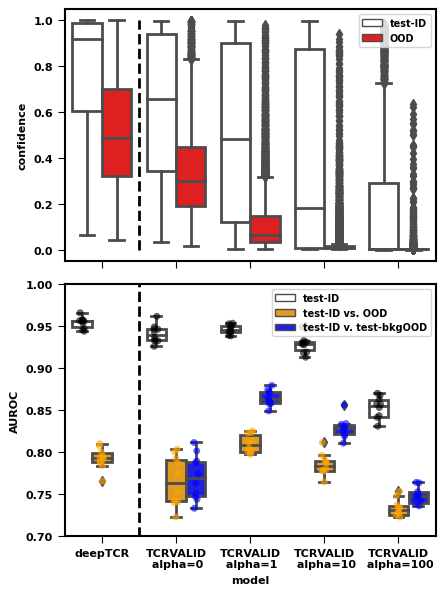

In [8]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(4.5,6))

# --------------------------------------
# OOD data was not used in model - remove test from naming convention
df_renamed = df.copy()
df_renamed['data'].replace('test-OOD','OOD', inplace=True)

g = sns.boxplot(
    data = df_renamed,
    x = 'model',
    hue= 'data',
    y = 'confidence',
    palette={'test-ID':'w','OOD':'r'},
    ax=ax1
)

ax1.plot([0.5,0.5],[0,1],'k--')

g.legend(loc='upper right', fontsize=7)

# --------------------------------------

hue_order = [
    'test-ID',
    'test-ID vs. OOD',
    'test-ID v. test-bkgOOD',
]

palette = {
    'test-ID':'w',
    'test-ID vs. OOD':'orange',
    'test-ID v. test-bkgOOD':'b'
}
palette2 = {
    'test-ID':'k',
    'test-ID vs. OOD':'orange',
    'test-ID v. test-bkgOOD':'b'
}
g2 = sns.boxplot(
    data = df_rocs,
    x = 'model',
    hue = 'roc_type',
    hue_order = hue_order,
    palette=palette,
    y = 'roc',
    color='r',
    ax=ax2
)

gg2 = sns.stripplot(
    data = df_rocs,
    x = 'model',
    hue = 'roc_type',
    hue_order = hue_order,
    palette=palette2,
    dodge=True,
    alpha=0.6,
    s=5,
    y = 'roc',
    color='r',
    ax=ax2
)
g2.legend(loc='upper right', fontsize=7)
handles, labels = g2.get_legend_handles_labels()


ax2.legend(handles[:3], labels[:3], loc='upper right', fontsize=7)


ax2.plot([0.5,0.5],[0,1],'k--')
ax2.set_ylim([0.7,1.0])
ax2.set_ylabel('AUROC')

for ax in [ax1,ax2]:
    ax.set_xlim([-0.5,4.5])
    
ax1.set_xticklabels([])
ax1.set_xlabel('')

plt.tight_layout()

plt.savefig('../results_data/classification_data/conf_AUROC_plot.pdf')
plt.savefig('../results_data/classification_data/conf_AUROC_plot.png')

In [9]:
# Mann-Whitney-U on ID v OOD classification task on 10 fold monte carlo - TCRVALID v DeepTCR

thetest = stats.mannwhitneyu(
        df_ood_roc[(df_ood_roc['model']=='deepTCR')].roc,
        df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=1')].roc
    )
print('p = ', thetest.pvalue)
print('U = ', thetest.statistic)

# AUROC means for TCRVALID, DEEPTCR over 10 fold monte carlo for ID v OOD
print('mean TCRVALID (alpha=1)  = {:.3f}'.format(df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=1')].roc.mean() ))
print('mean DeepTCR             = {:.3f}'.format(df_ood_roc[(df_ood_roc['model']=='deepTCR')].roc.mean() ))

# AUROC medians for TCRVALID, DEEPTCR over 10 fold monte carlo for ID v OOD
print('median TCRVALID (alpha=1)  = {:.3f}'.format(df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=1')].roc.median() ))
print('median DeepTCR             = {:.3f}'.format(df_ood_roc[(df_ood_roc['model']=='deepTCR')].roc.median() ))


p =  0.002293196040126747
U =  12.0
mean TCRVALID (alpha=1)  = 0.810
mean DeepTCR             = 0.792
median TCRVALID (alpha=1)  = 0.808
median DeepTCR             = 0.792


In [10]:
# Mann-Whitney-U on ID v OOD classification task on 10 fold monte carlo - TCRVALID alpha 0 vs 1
thetest = stats.mannwhitneyu(
        df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=0')].roc,
        df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=1')].roc
    )
print('p = ', thetest.pvalue)
print('statistic = ', thetest.statistic)

print('mean TCRVALID (alpha=0)  = {:.3f}'.format( df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=0')].roc.mean() ))
print('mean TCRVALID (alpha=1)  = {:.3f}'.format( df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=1')].roc.mean() ))

print('median TCRVALID (alpha=0)  = {:.3f}'.format( df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=0')].roc.median() ))
print('median TCRVALID (alpha=1)  = {:.3f}'.format( df_ood_roc[(df_ood_roc['model']=='TCRVALID\n alpha=1')].roc.median() ))


p =  0.0006574723348566069
statistic =  7.0
mean TCRVALID (alpha=0)  = 0.765
mean TCRVALID (alpha=1)  = 0.810
median TCRVALID (alpha=0)  = 0.763
median TCRVALID (alpha=1)  = 0.808


In [11]:
# Mann-Whitney-U on ID classification task on 10 fold monte carlo - DeepTCR vs TCRVALID
thetest = stats.mannwhitneyu(
        df_roc[(df_roc['model']=='deepTCR')].roc,
        df_roc[(df_roc['model']=='TCRVALID\n alpha=1')].roc
    )

print('p = ', thetest.pvalue)
print('statistic = ', thetest.statistic)

print('mean TCRVALID (alpha=1)  = {:.3f}'.format( df_roc[(df_roc['model']=='TCRVALID\n alpha=1')].roc.mean() ))
print('mean DeepTCR             = {:.3f}'.format( df_roc[(df_roc['model']=='deepTCR')].roc.mean() ) )


print('median TCRVALID (alpha=1)  = {:.3f}'.format( df_roc[(df_roc['model']=='TCRVALID\n alpha=1')].roc.median() ))
print('median DeepTCR             = {:.3f}'.format( df_roc[(df_roc['model']=='deepTCR')].roc.median() ) )


p =  0.004554248199015482
statistic =  15.0
mean TCRVALID (alpha=1)  = 0.946
mean DeepTCR             = 0.954
median TCRVALID (alpha=1)  = 0.945
median DeepTCR             = 0.956


In [12]:
# Mann-Whitney-U on ID classification task on 10 fold monte carlo -  TCRVALID, alpha=0, vs 1

thetest = stats.mannwhitneyu(
        df_roc[(df_roc['model']=='TCRVALID\n alpha=0')].roc,
        df_roc[(df_roc['model']=='TCRVALID\n alpha=1')].roc
    )

print('p = ', thetest.pvalue)
print('statistic = ', thetest.statistic)

print('mean TCRVALID (alpha=0)  = {:.3f}'.format( df_roc[(df_roc['model']=='TCRVALID\n alpha=0')].roc.mean() ))
print('mean TCRVALID (alpha=1)  = {:.3f}'.format( df_roc[(df_roc['model']=='TCRVALID\n alpha=1')].roc.mean() ))

print('median TCRVALID (alpha=0)  = {:.3f}'.format( df_roc[(df_roc['model']=='TCRVALID\n alpha=0')].roc.median() ))
print('median TCRVALID (alpha=1)  = {:.3f}'.format( df_roc[(df_roc['model']=='TCRVALID\n alpha=1')].roc.median() ))



p =  0.06061225150645831
statistic =  29.0
mean TCRVALID (alpha=0)  = 0.941
mean TCRVALID (alpha=1)  = 0.946
median TCRVALID (alpha=0)  = 0.940
median TCRVALID (alpha=1)  = 0.945
